In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report

# Defining Reusable Functions

In [2]:
def correlation_heatmap(df: pd.DataFrame, x=8, y=6, dpi=100) :
    # First calculate the correlation matrix using pandas
    correlation_matrix = df.corr()
    
    # Create the heatmap using seaborn
    plt.figure(figsize=(x, y), dpi=dpi)
    sns.heatmap(correlation_matrix, 
                annot=True,  # This shows the numbers in each cell
                fmt='.2f',   # Format to 2 decimal places
                cmap='RdBu_r',  # This gives you the red-white-blue colormap similar to the image
                center=0,     # Centers the colormap at 0
                square=True,  # Makes the cells square
                vmin=-1,     # Sets the minimum value for the colormap
                vmax=1)      # Sets the maximum value for the colormap
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Optional: adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [3]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [4]:
def StandardScale(df, columns_to_ignore):
    df_to_scale = df.drop(columns_to_ignore, axis=1)
    
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns, index=df.index)
    
    for col in columns_to_ignore:
        scaled_df[col] = df[col]
    
    return scaled_df

# Parquet File Analysis

The Project consists of Parquet Files containing Accelerometer data. We're doing some preliminary analysis on the parquet files.

## Analysing the first available Parquet File

In [4]:
%%skip
dirs = [d for d in Path('series_train.parquet').iterdir() if d.is_dir()]

def analyse_parquet(parquet_file: Path) :
  return pd.read_parquet(parquet_file)
  
for dir in dirs:
  row_id = str(dir).split("id=")[1]
  parquet_file = next(dir.glob("*.parquet"))

df = analyse_parquet(parquet_file)
df.head()

In [5]:
%%skip
df.columns

### Removing Rows where accelerometer hasn't been worn

In [6]:
%%skip
rows_before = len(df)

# Apply filter
df = df[df['non-wear_flag'] != 1]

# Count rows after filtering
rows_after = len(df)

# Calculate number of rows removed
rows_removed = rows_before - rows_after
rows_removed

### Analaysis of Accelerometer data wrt Time of day (hours)

In [7]:
%%skip
# Convert nanoseconds to hours of day
# First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
df['time_of_day_hours'] = ((df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)
df['time_of_day_hours'].head()

In [8]:
%%skip
# Create a single DataFrame with means of all desired columns
avg_df_hours = df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_hours.head()

In [9]:
%%skip
def get_figure(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    ax.set_xticks(range(0, 24))
    ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

In [10]:
%%skip
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure(ax1, avg_df_hours['time_of_day_hours'], avg_df_hours['enmo'], 
          'Average ENMO by Time of Day', 
          'Time of Day (hours)', 
          'Average ENMO')

get_figure(ax2, avg_df_hours['time_of_day_hours'], avg_df_hours['light'], 
          'Average Light Level by Time of Day', 
          'Time of Day (hours)', 
          'Average Light (lux)')

get_figure(ax3, avg_df_hours['time_of_day_hours'], avg_df_hours['X'], 
          'Average X Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average X Acceleration (g)')

get_figure(ax4, avg_df_hours['time_of_day_hours'], avg_df_hours['Y'], 
          'Average Y Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Y Acceleration (g)')

get_figure(ax5, avg_df_hours['time_of_day_hours'], avg_df_hours['Z'], 
          'Average Z Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Z Acceleration (g)')

get_figure(ax6, avg_df_hours['time_of_day_hours'], avg_df_hours['anglez'], 
          'Average Angle Z by Time of Day', 
          'Time of Day (hours)', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

In [11]:
%%skip
# First calculate the correlation matrix using pandas
correlation_heatmap(avg_df_hours.drop('time_of_day_hours', axis=1))

In [12]:
%%skip
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['X', 'Y', 'Z', 'anglez', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
flat_df = flat_df.reindex(sorted(flat_df.columns), axis=1)

flat_df

### Now evaluating the average data per weekday

In [13]:
%%skip
def get_continuous_sequence(numbers):
    # Convert pandas Series to list if needed
    if hasattr(numbers, 'tolist'):
        numbers = numbers.tolist()
    
    # Now check for empty list
    if not numbers or len(numbers) == 0:
        return []
        
    continuous = [numbers[0]]  # Initialize with first number
    for i in range(1, len(numbers)):
        current = numbers[i]
        prev = numbers[i-1]
        
        # If current number is less than previous, it means we've started a new week
        if current < prev:
            # Add 7 to make it continue from the previous week
            continuous.append(continuous[-1] + (current - prev + 7))
        # If current equals previous, keep the same continuous number
        elif current == prev:
            continuous.append(continuous[-1])
        # If current is greater than previous, add the difference
        else:
            continuous.append(continuous[-1] + (current - prev))
            
    return continuous

In [14]:
%%skip
df['continuous_weekdays'] = get_continuous_sequence(df['weekday']) 
df['continuous_weekdays'].unique()

In [15]:
%%skip
# Create a single DataFrame with means of all desired columns
avg_df_weekday = df.groupby('continuous_weekdays')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_weekday.head()

In [16]:
%%skip
def get_figure_weekday(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    # Set x-axis ticks
    # ax.set_xticks(range(len(x)))  # This sets a tick for each x value
    # ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

In [17]:
%%skip
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure_weekday(ax1, avg_df_weekday['continuous_weekdays'], avg_df_weekday['enmo'], 
          'Average ENMO by Weekday', 
          'Weekday', 
          'Average ENMO')

get_figure_weekday(ax2, avg_df_weekday['continuous_weekdays'], avg_df_weekday['light'], 
          'Average Light Level by Weekday', 
          'Weekday', 
          'Average Light (lux)')

get_figure_weekday(ax3, avg_df_weekday['continuous_weekdays'], avg_df_weekday['X'], 
          'Average X Acceleration by Weekday', 
          'Weekday', 
          'Average X Acceleration (g)')

get_figure_weekday(ax4, avg_df_weekday['continuous_weekdays'], avg_df_weekday['Y'], 
          'Average Y Acceleration by Weekday', 
          'Weekday',  
          'Average Y Acceleration (g)')

get_figure_weekday(ax5, avg_df_weekday['continuous_weekdays'], avg_df_weekday['Z'], 
          'Average Z Acceleration by Weekday', 
          'Weekday', 
          'Average Z Acceleration (g)')

get_figure_weekday(ax6, avg_df_weekday['continuous_weekdays'], avg_df_weekday['anglez'], 
          'Average Angle Z by Weekday', 
          'Weekday', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

In [18]:
%%skip
# First calculate the correlation matrix using pandas
correlation_heatmap(avg_df_weekday.drop('continuous_weekdays', axis=1))

### Conclusions from Analysis

1. Anglez and Z are heavily correlated.
2. X, Y and Z may not be quite as useful as Enmo. Initially discarding the data. If we do not get satisfactory results, we shall consider using X, Y and Z again.
3. Light and Enmo are correlated, but since we're using just one child's Accelerometer data, it might not be the same throughout. Hence, we should ideally keep them both in.

### Flattening Hourly Data

In [19]:
%%skip
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['enmo', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_h{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
hourly_flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
# hourly_flat_df = hourly_flat_df.reindex(sorted(hourly_flat_df.columns), axis=1)

hourly_flat_df

### Flattening Weekday Data

In [20]:
%%skip
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create columns for each unique weekday
for var in ['enmo', 'light']:
    # Get the unique weekdays in sorted order
    unique_weekdays = sorted(avg_df_weekday['continuous_weekdays'].unique())
    
    for weekday in unique_weekdays:
        # Get the value for this weekday
        value = avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday].empty else None
        # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
        col_name = f'{var}_w{weekday}'
        flattened_data[col_name] = [value]

# Create new dataframe
weekday_flat_df = pd.DataFrame(flattened_data)
# Optionally, sort columns to group variables together
# weekday_flat_df = weekday_flat_df.reindex(sorted(weekday_flat_df.columns), axis=1)
weekday_flat_df

### Creating a combined dataframe

In [21]:
%%skip
combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
combined_df.head()

## Function for appending averaged Parquet File into Main CSV File

In [22]:
def extract_id(path):
    return path.split('id=')[1].split('\\')[0]

def get_combined_avg(parquet_file: Path, n: int) :

    if n%50 == 0: print(f"{n} files processed")

    row_id = extract_id(str(parquet_file))
    # print('Analysing data for id: '+row_id)
    
    df = pd.read_parquet(parquet_file)
    
    # Apply filter
    df = df[df['non-wear_flag'] != 1]

    # Convert nanoseconds to hours of day
    # First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
    df['time_of_day_hours'] = ((df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)

    # Create a single DataFrame with means of all desired columns
    avg_df_hours = df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create 24 columns
    for var in ['enmo', 'light']:
        for hour in range(24):
            # Get the value for this hour
            value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
            # Create new column name (e.g., 'X_1', 'X_2', etc.)
            col_name = f'{var}_h{hour}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    hourly_flat_df = pd.DataFrame(flattened_data)

    df['continuous_weekdays'] = get_continuous_sequence(df['weekday']) 
    
    # Create a single DataFrame with means of all desired columns
    avg_df_weekday = df.groupby('continuous_weekdays')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create columns for each unique weekday
    for var in ['enmo', 'light']:
        # Get the unique weekdays in sorted order
        unique_weekdays = sorted(avg_df_weekday['continuous_weekdays'].unique())
        
        for weekday in unique_weekdays:
            # Get the value for this weekday
            value = avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday].empty else None
            # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
            col_name = f'{var}_w{weekday}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    weekday_flat_df = pd.DataFrame(flattened_data)

    combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
    combined_df['id'] = row_id
    
    return combined_df

In [23]:
%%skip
dirs = [d for d in Path('series_train.parquet').iterdir() if d.is_dir()]
print(f'Total numbers of parquet_files to process: {len(dirs)}')
df_list = []  # Create empty list to store DataFrames
n = 0

for dir in dirs:
    row_id = str(dir).split("id=")[1]
    parquet_file = next(dir.glob("*.parquet"))
    temp_df = get_combined_avg(parquet_file, n)  # Gets single row DataFrame
    df_list.append(temp_df)
    n+=1

# Combine all DataFrames at once
final_df = pd.concat(df_list, ignore_index=True)
final_df = final_df.reindex(sorted(final_df.columns, key=str.lower), axis=1)
final_df.head()

In [24]:
%%skip
final_df.to_csv('avg_parquet.csv')

# Analysing Main CSV File

In [20]:
df = pd.read_csv('train.csv')

In [21]:
df = df.drop(['Basic_Demos-Enroll_Season',
'CGAS-Season',
'Physical-Season',
'Physical-Waist_Circumference',
'Physical-Height',
'Physical-Weight',
'Fitness_Endurance-Season',
'Fitness_Endurance-Max_Stage',
'Fitness_Endurance-Time_Mins',	
'Fitness_Endurance-Time_Sec',
'FGC-Season',
'FGC-FGC_CU',
'FGC-FGC_CU_Zone',	
'FGC-FGC_GSND',	
'FGC-FGC_GSND_Zone',	
'FGC-FGC_GSD',	
'FGC-FGC_GSD_Zone',	
'FGC-FGC_PU',
'FGC-FGC_SRL',
'FGC-FGC_SRR',
'FGC-FGC_TL',
'BIA-Season',
'BIA-BIA_BMC',
'BIA-BIA_BMI',
'BIA-BIA_BMR',
'BIA-BIA_ECW',
'BIA-BIA_FFM',
'BIA-BIA_FFMI',
'BIA-BIA_FMI',
'PAQ_A-Season',	
'PAQ_A-PAQ_A_Total',
'PAQ_C-Season',	
'PAQ_C-PAQ_C_Total',	
'PCIAT-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'BIA-BIA_ICW',
'BIA-BIA_LDM',
'BIA-BIA_LST',
'BIA-BIA_SMM',
'SDS-SDS_Total_Raw'], axis=1)

short_df = df.drop(['PCIAT-PCIAT_01',
'PCIAT-PCIAT_02',
'PCIAT-PCIAT_03',
'PCIAT-PCIAT_04',
'PCIAT-PCIAT_05',
'PCIAT-PCIAT_06',
'PCIAT-PCIAT_07',
'PCIAT-PCIAT_08',
'PCIAT-PCIAT_09',
'PCIAT-PCIAT_10',
'PCIAT-PCIAT_11',
'PCIAT-PCIAT_12',
'PCIAT-PCIAT_13',
'PCIAT-PCIAT_14',
'PCIAT-PCIAT_15',
'PCIAT-PCIAT_16',
'PCIAT-PCIAT_17',
'PCIAT-PCIAT_18',
'PCIAT-PCIAT_19',
'PCIAT-PCIAT_20'], axis=1)

short_df.describe()

Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.433586         0.372727        65.454771     19.331929   
std           3.574648         0.483591        22.341862      5.113934   
min           5.000000         0.000000        25.000000      0.000000   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          22.000000         1.000000       999.000000     59.132048   

       Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  \
count            2954.000000         2967.000000           2954.000000   
mean               69.648951           81.597236            116.983074   
std                13.611226           13.665196             17.061225   
min                 0.000000           27.000000              0.000000   
25%                61.000000           72.000000            107.000000   
50%                68.000000           81.000000            114.000000   
75%                76.000000           90.500000            125.000000   
max               179.000000          138.000000            203.000000   

       FGC-FGC_PU_Zone  FGC-FGC_SRL_Zone  FGC-FGC_SRR_Zone  FGC-FGC_TL_Zone  \
count      2271.000000       2267.000000       2269.000000      2285.000000   
mean          0.330251          0.618880          0.620097         0.785558   
std           0.470407          0.485769          0.485469         0.410525   
min           0.000000          0.000000          0.000000         0.000000   
25%           0.000000          0.000000          0.000000         1.000000   
50%           0.000000          1.000000          1.000000         1.000000   
75%           1.000000          1.000000          1.000000         1.000000   
max           1.000000          1.000000          1.000000         1.000000   

       BIA-BIA_Activity_Level_num    BIA-BIA_DEE  BIA-BIA_Fat  \
count                 1991.000000    1991.000000  1991.000000   
mean                     2.651431    2064.693747    16.855020   
std                      1.028267    2836.246272   199.372119   
min                      1.000000    1073.450000 -8745.080000   
25%                      2.000000    1605.785000     8.602395   
50%                      3.000000    1863.980000    16.174600   
75%                      3.000000    2218.145000    30.273100   
max                      5.000000  124728.000000   153.820000   

       BIA-BIA_Frame_num  BIA-BIA_TBW  PCIAT-PCIAT_Total  SDS-SDS_Total_T  \
count        1991.000000  1991.000000        2736.000000      2606.000000   
mean            1.745354    53.998726          27.896199        57.763622   
std             0.680635   129.362539          20.338853        13.196091   
min             1.000000    20.589200           0.000000        38.000000   
25%             1.000000    35.887000          12.000000        47.000000   
50%             2.000000    44.987000          26.000000        55.000000   
75%             2.000000    60.271050          41.000000        64.000000   
max             3.000000  5690.910000          93.000000       100.000000   

       PreInt_EduHx-computerinternet_hoursday          sii  
count                             3301.000000  2736.000000  
mean                                 1.060588     0.580409  
std                                  1.094875     0.771122  
min                                  0.000000     0.000000  
25%                                  0.000000     0.000000  
50%                                  1.000000     0.000000  
75%                                  2.000000     1.000000  
max                                  3.000000     3.000000

In [22]:
df.columns

Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate',
       'Physical-Systolic_BP', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_DEE', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_TBW',
       'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
       'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12',
       'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16',
       'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20',
       'PCIAT-PCIAT_Total', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'sii'],
      dtype='object')

In [23]:
correlation_heatmap(short_df.drop('id', axis=1), 26, 26, 420)

# Initial Visualizations

<Axes: xlabel='Basic_Demos-Age', ylabel='count'>

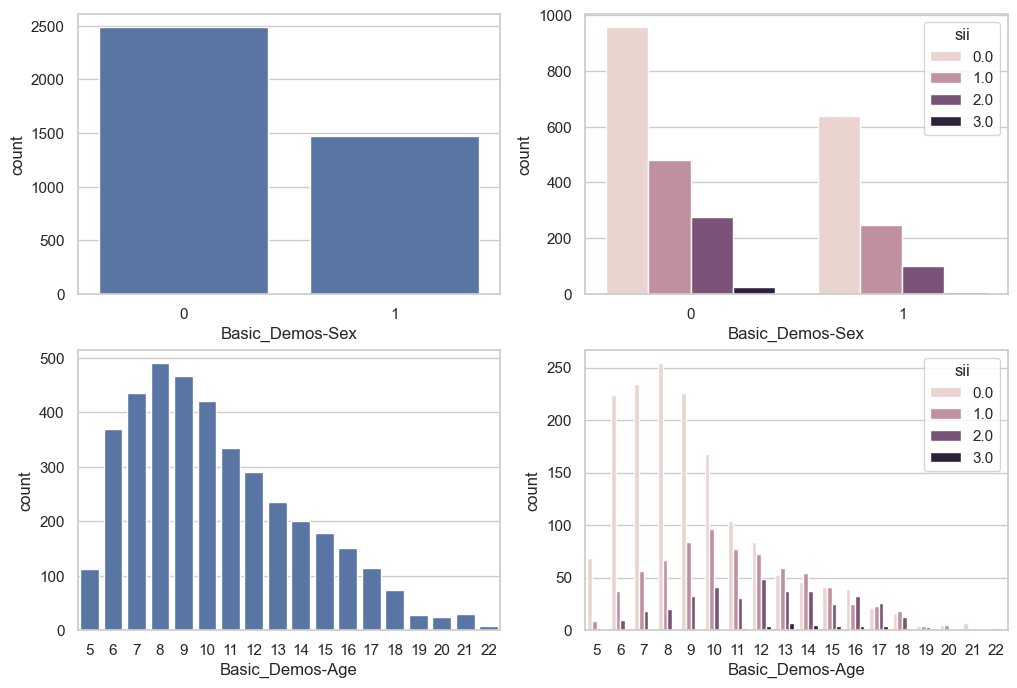

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

sns.countplot(x = 'Basic_Demos-Sex', data = df, ax=ax1)
sns.countplot(x ='Basic_Demos-Sex', hue = "sii", data = df, ax=ax2)
sns.countplot(x = 'Basic_Demos-Age', data = df, ax=ax3)
sns.countplot(x ='Basic_Demos-Age', hue = "sii", data = df, ax=ax4)

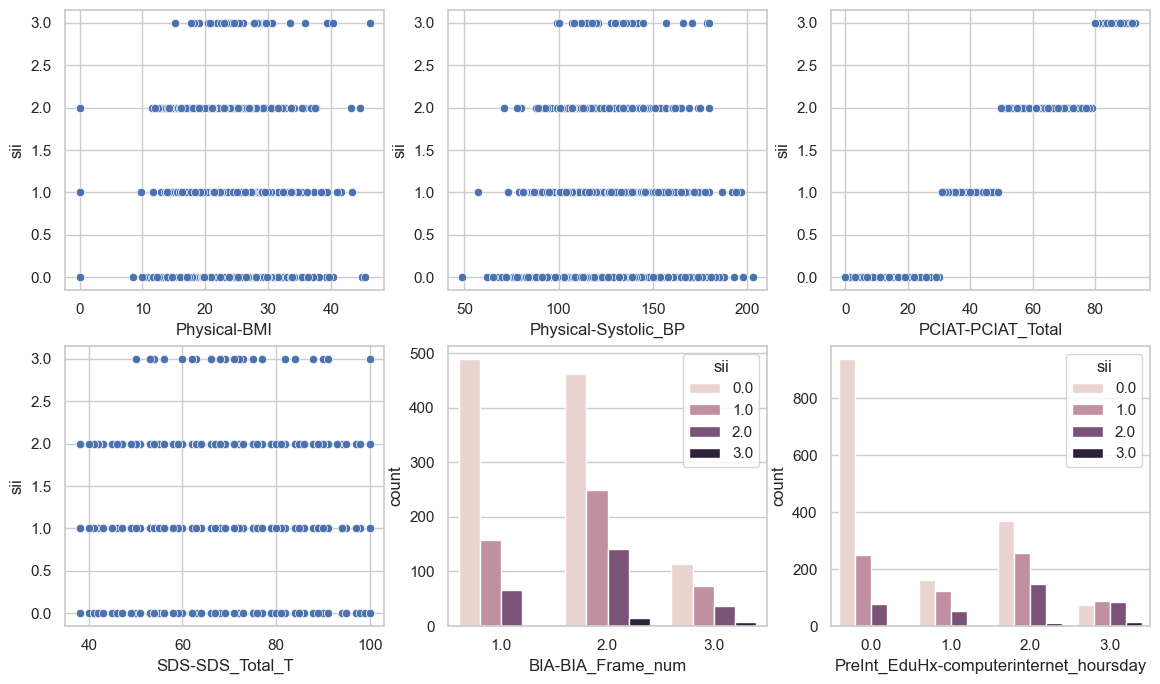

In [25]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14,8))

sns.set(style='whitegrid')

sns.scatterplot(x=df["Physical-BMI"], y=df["sii"], data=df, ax=ax1)
sns.scatterplot(x=df["Physical-Systolic_BP"], y=df["sii"], data=df, ax=ax2)
sns.scatterplot(x=df["PCIAT-PCIAT_Total"], y=df["sii"], data=df, ax=ax3)
sns.scatterplot(x=df["SDS-SDS_Total_T"], y=df["sii"], data=df, ax=ax4)
sns.countplot(x ='BIA-BIA_Frame_num', hue = "sii", data = df, ax=ax5)
sns.countplot(x ='PreInt_EduHx-computerinternet_hoursday', hue = "sii", data = df, ax=ax6)

plt.show()

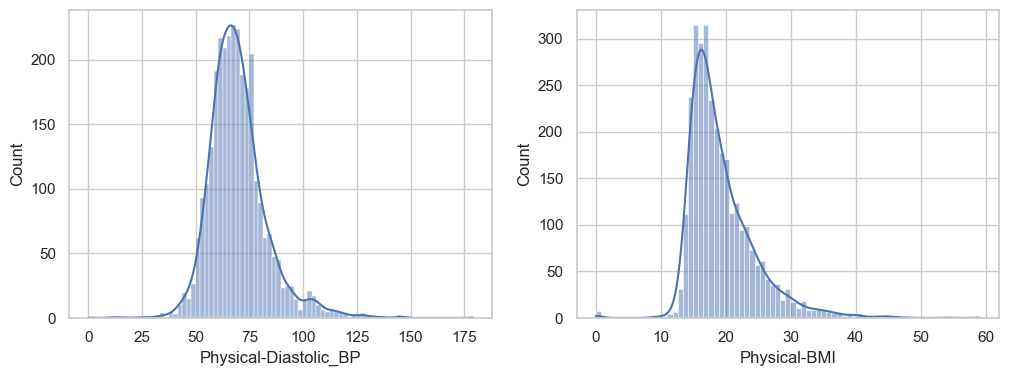

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# ax1.scatter(df['Physical-Diastolic_BP'], df['Physical-Systolic_BP'])
sns.histplot(data=df, x='Physical-Diastolic_BP', kde=True, ax=ax1)
sns.histplot(data=df, x='Physical-BMI', kde=True, ax=ax2)
plt.show()

# Data Cleaning

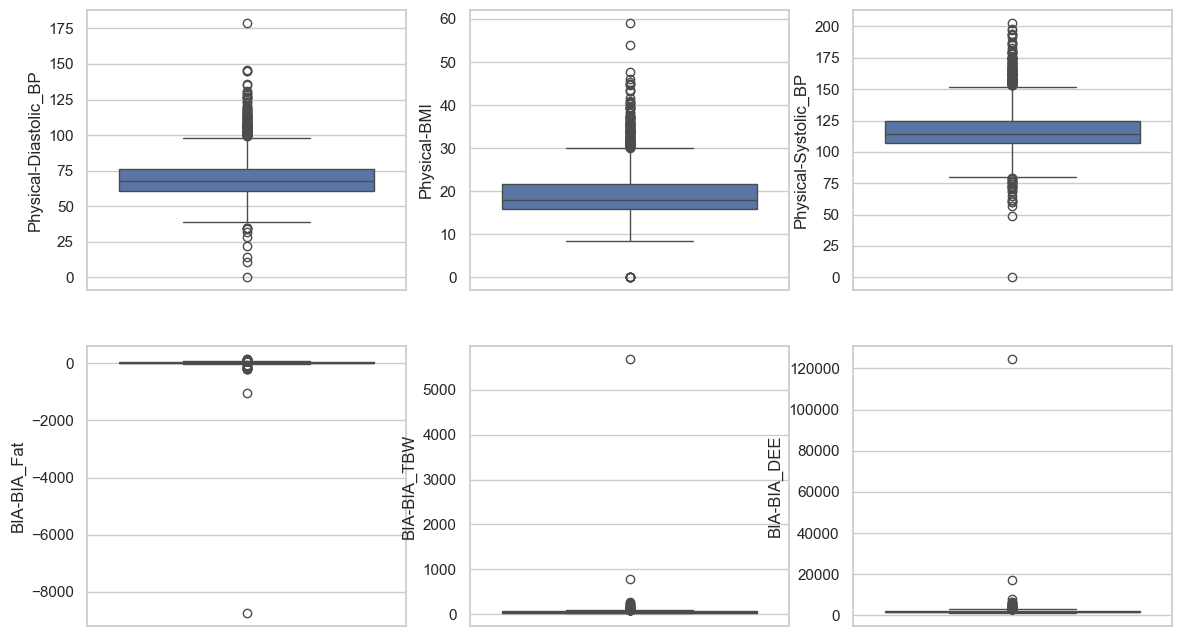

In [27]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.boxplot(y=df['Physical-Diastolic_BP'], ax=ax1)
sns.boxplot(y=df['Physical-BMI'], ax=ax2)
sns.boxplot(y=df['Physical-Systolic_BP'], ax=ax3)
sns.boxplot(y=df['BIA-BIA_Fat'], ax=ax4)
sns.boxplot(y=df['BIA-BIA_TBW'], ax=ax5)
sns.boxplot(y=df['BIA-BIA_DEE'], ax=ax6)

plt.show()

### Recommended Levels of Vitals 

The following are the minimum and maximum possible values of the vitals in humans, according to various sources.

1. Diastolic BP :
   A. Minimum : 60
   B. Maximum : 150

In [28]:
diastole = len(df[(df['Physical-Diastolic_BP'] > 150) | (df['Physical-Diastolic_BP'] < 37)])
systole = len(df[df['Physical-Systolic_BP'] < 50])
bmi = len(df[(df['Physical-BMI'] == 0) | (df['Physical-BMI'] > 50)])
fat = len(df[df['BIA-BIA_Fat'] <= 0])
tbw = len(df[df['BIA-BIA_TBW'] > 500])
dee = len(df[df['BIA-BIA_DEE'] > 5000])

combined_count = len(df[
    ((df['Physical-Diastolic_BP'] > 150) | (df['Physical-Diastolic_BP'] < 37)) |
    (df['Physical-Systolic_BP'] < 50) |
    ((df['Physical-BMI'] == 0) | (df['Physical-BMI'] > 50)) |
    (df['BIA-BIA_Fat'] <= 0) |
    (df['BIA-BIA_TBW'] > 500) |
    (df['BIA-BIA_DEE'] > 5000)
])

print(diastole, systole, bmi, fat, tbw, dee, combined_count)

11 2 9 35 2 11 57


In [29]:
df = df[~(
   ((df['Physical-Diastolic_BP'] > 150) | (df['Physical-Diastolic_BP'] < 37)) |
   (df['Physical-Systolic_BP'] < 50) |
   ((df['Physical-BMI'] == 0) | (df['Physical-BMI'] > 50)) |
   (df['BIA-BIA_Fat'] <= 0) |
   (df['BIA-BIA_TBW'] > 500) |
   (df['BIA-BIA_DEE'] > 5000)
)]

df.shape

(3903, 41)

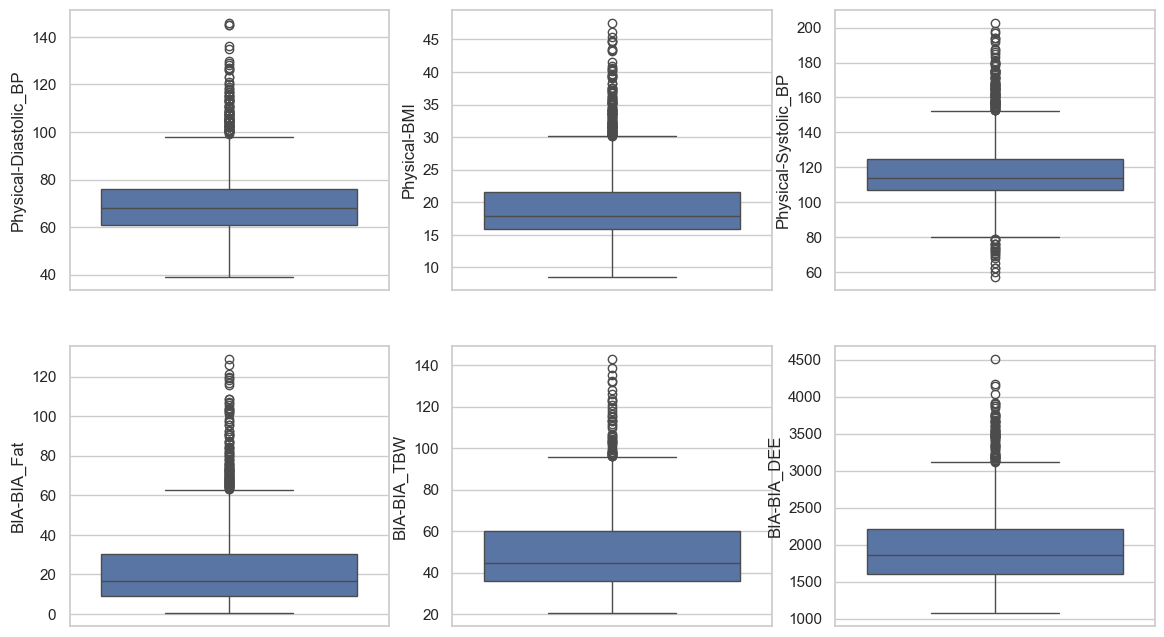

In [30]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.boxplot(y=df['Physical-Diastolic_BP'], ax=ax1)
sns.boxplot(y=df['Physical-BMI'], ax=ax2)
sns.boxplot(y=df['Physical-Systolic_BP'], ax=ax3)
sns.boxplot(y=df['BIA-BIA_Fat'], ax=ax4)
sns.boxplot(y=df['BIA-BIA_TBW'], ax=ax5)
sns.boxplot(y=df['BIA-BIA_DEE'], ax=ax6)

plt.show()

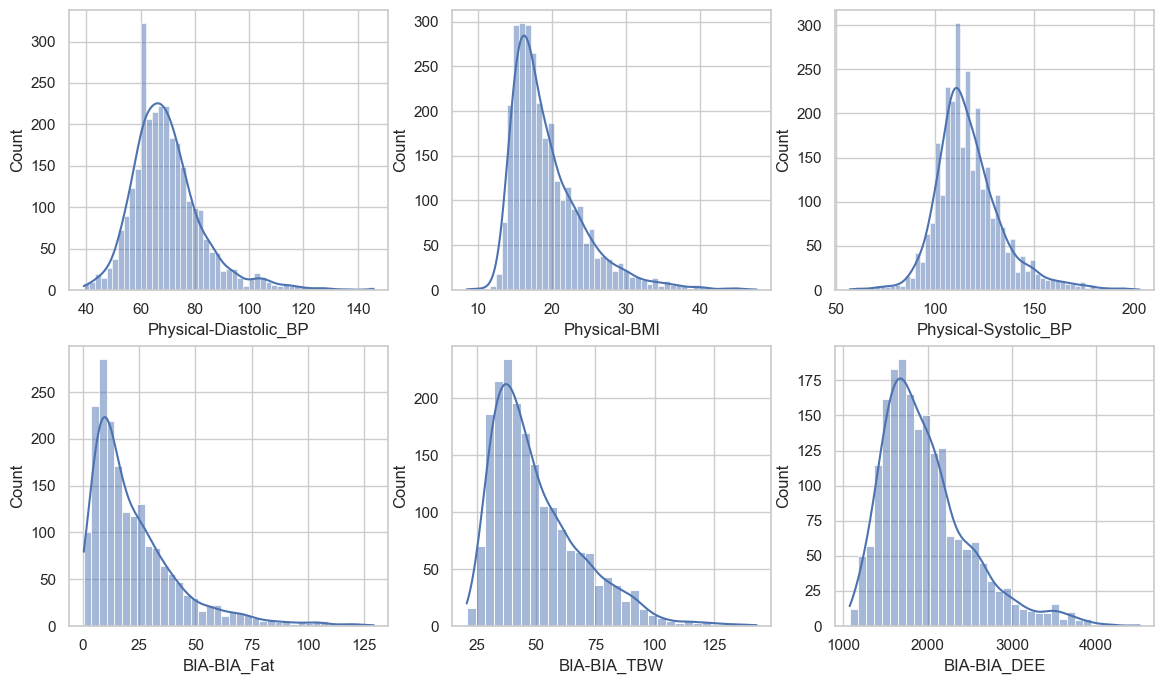

In [31]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=df['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=df['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=df['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=df['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=df['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=df['BIA-BIA_DEE'], ax=ax6)
plt.show()

# Missing data and Data Imputation

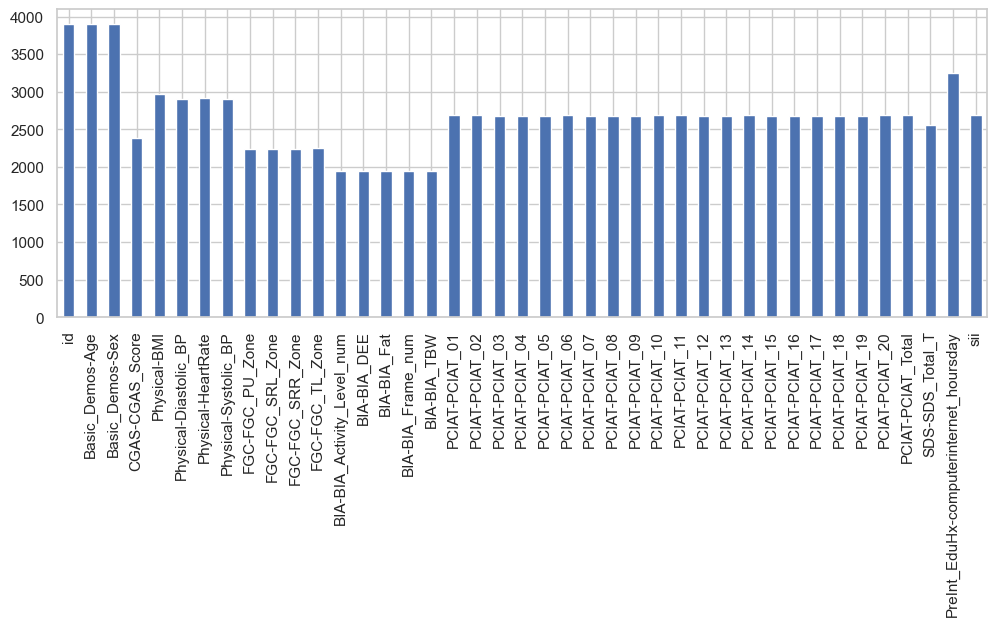

In [32]:
counts = df.count()

plt.figure(figsize=(12,4))
counts.plot(kind='bar')
plt.show()

In [34]:
def analyze_missingness(df, columns=None):
    """
    Analyze missing patterns for multiple columns
    
    Parameters:
    df: pandas DataFrame
    columns: list of columns to analyze. If None, analyzes all columns
    """
    # If no columns specified, analyze all columns
    if columns is None:
        columns = df.columns
    elif isinstance(columns, str):
        columns = [columns]
    
    # 1. Missing statistics for all specified columns
    missing_stats = df[columns].isnull().sum()
    missing_rate = (missing_stats / len(df) * 100).round(2)
    
    print("\nMissing Statistics:")
    for col, (count, rate) in zip(missing_stats.index, zip(missing_stats, missing_rate)):
        if count > 0:  # Only show columns with missing values
            print(f"{col}: {count} missing ({rate}%)")
    
    # 2. Correlation between missing patterns
    cols_with_missing = [col for col in columns if df[col].isnull().any()]
    if len(cols_with_missing) > 1:
        print("\nCorrelation between missing patterns:")
        missing_correlation = df[cols_with_missing].isnull().corr()
        # Show only correlations > 0.1
        for i in range(len(cols_with_missing)):
            for j in range(i+1, len(cols_with_missing)):
                corr = missing_correlation.iloc[i,j]
                if abs(corr) > 0.1:
                    print(f"{cols_with_missing[i]} - {cols_with_missing[j]}: {corr:.3f}")
    
    # 3. Test relationships with other variables
    print("\nSignificant relationships with other variables (p < 0.05):")

    num_rel_col = []
    cat_rel_col = []
    
    for col in cols_with_missing:
        missing_mask = df[col].isnull()
        if missing_mask.sum() == 0:
            continue
            
        print(f"\n{col}:")
        
        # Test against other numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for num_col in numeric_cols:
            if num_col != col and df[num_col].nunique() > 1:
                complete = df[~missing_mask][num_col].dropna()
                missing = df[missing_mask][num_col].dropna()
                if len(complete) > 0 and len(missing) > 0:
                    try:
                        stat, pval = stats.ttest_ind(complete, missing)
                        if pval < 0.05:
                            num_rel_col.append(num_col)
                    except:
                        continue
        
        # Test against categorical columns
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        for cat_col in cat_cols:
            if cat_col != col and df[cat_col].nunique() > 1:
                contingency = pd.crosstab(missing_mask, df[cat_col])
                try:
                    stat, pval = stats.chi2_contingency(contingency)[:2]
                    if pval < 0.05:
                        cat_rel_col.append(cat_col)
                except:
                    continue

        print(f"Numerical columns : {num_rel_col}")
        print(f"Categorical columns : {cat_rel_col}")
    
    # 4. Visualize missing patterns
    plt.figure(figsize=(10, len(cols_with_missing)/2 + 1))
    sns.heatmap(df[cols_with_missing].isnull().T, 
                cmap='viridis',
                cbar=False,
                yticklabels=True)
    plt.title('Missing Data Patterns')
    plt.xlabel('Row Index')
    plt.ylabel('Columns')
    plt.show()
    
    # 5. Provide interpretation for each column
    print("\nInterpretation:")
    for col in cols_with_missing:
        print(f"\n{col}:")
        missing_mask = df[col].isnull()
        
        # Check for relationships with other variables
        has_relationships = False
        for other_col in df.columns:
            if other_col != col and df[other_col].nunique() > 1:
                if df[other_col].dtype in ['int64', 'float64']:
                    complete = df[~missing_mask][other_col].dropna()
                    missing = df[missing_mask][other_col].dropna()
                    if len(complete) > 0 and len(missing) > 0:
                        try:
                            _, pval = stats.ttest_ind(complete, missing)
                            if pval < 0.05:
                                has_relationships = True
                                break
                        except:
                            continue
        
        if not has_relationships:
            print("- Likely MCAR: No significant relationships found with other variables")
        else:
            print("- Likely MAR: Missing values are related to other variables")


Missing Statistics:
CGAS-CGAS_Score: 1525 missing (39.07%)
BIA-BIA_Activity_Level_num: 1958 missing (50.17%)
FGC-FGC_PU_Zone: 1667 missing (42.71%)

Correlation between missing patterns:
CGAS-CGAS_Score - BIA-BIA_Activity_Level_num: 0.406
CGAS-CGAS_Score - FGC-FGC_PU_Zone: 0.231
BIA-BIA_Activity_Level_num - FGC-FGC_PU_Zone: 0.524

Significant relationships with other variables (p < 0.05):

CGAS-CGAS_Score:
Numerical columns : ['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-HeartRate', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Fat', 'BIA-BIA_TBW', 'PreInt_EduHx-computerinternet_hoursday']
Categorical columns : []

BIA-BIA_Activity_Level_num:
Numerical columns : ['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-HeartRate', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Fat', 'BIA-BIA_TBW', 'PreInt_EduHx-computeri

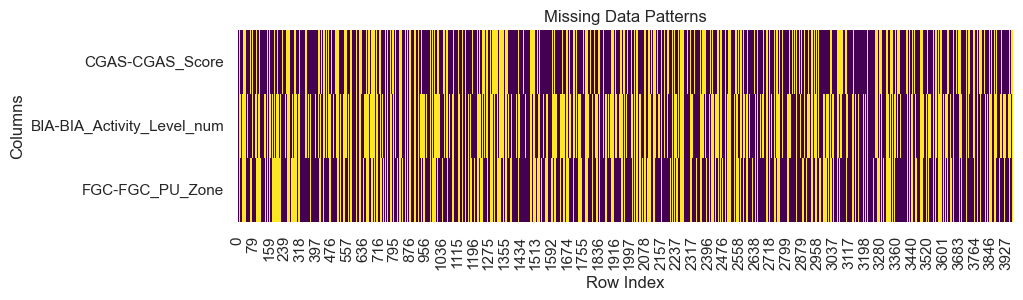


Interpretation:

CGAS-CGAS_Score:
- Likely MAR: Missing values are related to other variables

BIA-BIA_Activity_Level_num:
- Likely MAR: Missing values are related to other variables

FGC-FGC_PU_Zone:
- Likely MAR: Missing values are related to other variables


In [35]:
analyze_missingness(df, ['CGAS-CGAS_Score', 'BIA-BIA_Activity_Level_num', 'FGC-FGC_PU_Zone'])

In [36]:
categorical_columns = ['id', 'Basic_Demos-Sex', 
                        'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 
                        'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PCIAT-PCIAT_01',
                        'PCIAT-PCIAT_02',
                        'PCIAT-PCIAT_03',
                        'PCIAT-PCIAT_04',
                        'PCIAT-PCIAT_05',
                        'PCIAT-PCIAT_06',
                        'PCIAT-PCIAT_07',
                        'PCIAT-PCIAT_08',
                        'PCIAT-PCIAT_09',
                        'PCIAT-PCIAT_10',
                        'PCIAT-PCIAT_11',
                        'PCIAT-PCIAT_12',
                        'PCIAT-PCIAT_13',
                        'PCIAT-PCIAT_14',
                        'PCIAT-PCIAT_15',
                        'PCIAT-PCIAT_16',
                        'PCIAT-PCIAT_17',
                        'PCIAT-PCIAT_18',
                        'PCIAT-PCIAT_19',
                        'PCIAT-PCIAT_20']

categorical_columns_labeled = categorical_columns + ['sii']

In [37]:
def knn_impute_columns(df, columns_to_impute, n_neighbors=5, weights='uniform'):
    """
    KNN imputation for specific columns
    
    Parameters:
    df: pandas DataFrame
    columns_to_impute: list of column names to impute
    n_neighbors: number of neighbors to use
    weights: weight function used ('uniform' or 'distance')
    """
    # Create copy of original dataframe
    df_copy = df.copy()
    
    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
    
    # Perform imputation only on selected columns
    df_to_impute = df_copy[columns_to_impute]
    imputed_values = imputer.fit_transform(df_to_impute)
    
    # Update only the imputed columns
    df_copy[columns_to_impute] = imputed_values
    
    return df_copy

In [38]:
imputed_df = knn_impute_columns(df, columns_to_impute=df.drop(categorical_columns_labeled, axis=1).columns.tolist())
imputed_df[categorical_columns] = imputed_df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
imputed_df.describe()

Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3903.000000      3903.000000      3903.000000   3903.000000   
mean         10.434538         0.371765        68.334922     19.565807   
std           3.570877         0.483338        30.031650      4.610662   
min           5.000000         0.000000        25.000000      8.522436   
25%           8.000000         0.000000        60.000000     16.306554   
50%          10.000000         0.000000        65.000000     18.591736   
75%          13.000000         1.000000        70.200000     21.601283   
max          22.000000         1.000000       999.000000     47.603772   

       Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  \
count            3903.000000         3903.000000           3903.000000   
mean               70.077479           81.565719            117.654625   
std                11.926240           12.278113             15.491208   
min                39.000000           33.000000             57.000000   
25%                62.000000           74.000000            108.000000   
50%                69.000000           81.000000            116.000000   
75%                76.000000           89.000000            125.300000   
max               146.000000          138.000000            203.000000   

       FGC-FGC_PU_Zone  FGC-FGC_SRL_Zone  FGC-FGC_SRR_Zone  ...  \
count      3903.000000       3903.000000       3903.000000  ...   
mean          0.188573          0.781450          0.781706  ...   
std           0.391219          0.413315          0.413141  ...   
min           0.000000          0.000000          0.000000  ...   
25%           0.000000          1.000000          1.000000  ...   
50%           0.000000          1.000000          1.000000  ...   
75%           0.000000          1.000000          1.000000  ...   
max           1.000000          1.000000          1.000000  ...   

       PCIAT-PCIAT_15  PCIAT-PCIAT_16  PCIAT-PCIAT_17  PCIAT-PCIAT_18  \
count     3903.000000     3903.000000     3903.000000     3903.000000   
mean         1.030489        0.998207        1.117602        1.110428   
std          1.415968        1.408129        1.415574        1.471009   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000        0.000000   
75%          2.000000        2.000000        2.000000        2.000000   
max          5.000000        5.000000        5.000000        5.000000   

       PCIAT-PCIAT_19  PCIAT-PCIAT_20  PCIAT-PCIAT_Total  SDS-SDS_Total_T  \
count     3903.000000     3903.000000        3903.000000      3903.000000   
mean         0.798873        0.651038          28.198616        58.446989   
std          1.237455        1.077318          18.270687        12.020084   
min          0.000000        0.000000           0.000000        38.000000   
25%          0.000000        0.000000          15.500000        50.000000   
50%          0.000000        0.000000          27.000000        56.200000   
75%          1.000000        1.000000          39.000000        63.000000   
max          5.000000        5.000000          93.000000       100.000000   

       PreInt_EduHx-computerinternet_hoursday          sii  
count                             3903.000000  2688.000000  
mean                                 1.069331     0.580729  
std                                  1.037730     0.770811  
min                                  0.000000     0.000000  
25%                                  0.000000     0.000000  
50%                                  1.000000     0.000000  
75%                                  2.000000     1.000000  
max                                  3.000000     3.000000  

[8 rows x 40 columns]

# Defining X and Y

In [39]:
X = imputed_labeled_df.drop(['id','sii'], axis=1).columns.tolist()
Y = ['sii']

NameError: name 'imputed_labeled_df' is not defined

## Filling sii with imputation (RandomForestClassifier)

In [89]:
# Encode categorical variables first
imputed_labeled_df = imputed_df.copy()

model = RandomForestClassifier()
known_data = imputed_df[imputed_df['sii'].notna()]
model.fit(known_data[X], known_data['sii'])
imputed_labeled_df.loc[imputed_labeled_df['sii'].isna(), 'sii'] = model.predict(imputed_df[imputed_df['sii'].isna()][X])

# For both dataframes
print("Original:")
print(imputed_df['sii'].value_counts(dropna=False))
print("\nImputed:")
print(imputed_labeled_df['sii'].value_counts(dropna=False))

Original:
sii
0.0    1564
NaN    1215
1.0     721
2.0     369
3.0      34
Name: count, dtype: int64

Imputed:
sii
0.0    2192
1.0    1308
2.0     369
3.0      34
Name: count, dtype: int64


In [95]:
imputed_labeled_df.isnull().sum()[scaled_df.isnull().sum() > 0]

id                            0
Basic_Demos-Sex               0
FGC-FGC_PU_Zone               0
FGC-FGC_SRL_Zone              0
FGC-FGC_SRR_Zone              0
FGC-FGC_TL_Zone               0
BIA-BIA_Activity_Level_num    0
BIA-BIA_Frame_num             0
PCIAT-PCIAT_01                0
PCIAT-PCIAT_02                0
PCIAT-PCIAT_03                0
PCIAT-PCIAT_04                0
PCIAT-PCIAT_05                0
PCIAT-PCIAT_06                0
PCIAT-PCIAT_07                0
PCIAT-PCIAT_08                0
PCIAT-PCIAT_09                0
PCIAT-PCIAT_10                0
PCIAT-PCIAT_11                0
PCIAT-PCIAT_12                0
PCIAT-PCIAT_13                0
PCIAT-PCIAT_14                0
PCIAT-PCIAT_15                0
PCIAT-PCIAT_16                0
PCIAT-PCIAT_17                0
PCIAT-PCIAT_18                0
PCIAT-PCIAT_19                0
PCIAT-PCIAT_20                0
dtype: int64

## Scaling the Data

In [121]:
scaled_df = StandardScale(imputed_labeled_df, categorical_columns_labeled)
scaled_df.describe()

Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Diastolic_BP  \
count     3.903000e+03     3.903000e+03  3.903000e+03           3.903000e+03   
mean      1.028585e-16     8.601882e-17 -7.099966e-17           9.862581e-16   
std       1.000128e+00     1.000128e+00  1.000128e+00           1.000128e+00   
min      -1.522101e+00    -1.460776e+00 -2.401698e+00          -2.616970e+00   
25%      -6.818632e-01    -2.788681e-01 -7.183624e-01          -5.809147e-01   
50%      -1.217049e-01    -1.100241e-01 -2.505744e-01          -1.018429e-01   
75%       7.185326e-01     9.596548e-02  4.852507e-01           3.772289e-01   
max       3.239245e+00     3.143002e+01  6.135664e+00           6.536724e+00   

       Physical-HeartRate  Physical-Systolic_BP   BIA-BIA_DEE   BIA-BIA_Fat  \
count        3.903000e+03          3.903000e+03  3.903000e+03  3.903000e+03   
mean         2.321143e-17          1.806850e-16  4.187159e-17  2.184605e-17   
std          1.000128e+00          1.000128e+00  1.000128e+00  1.000128e+00   
min         -3.953643e+00         -3.962006e+00 -1.888088e+00 -1.386751e+00   
25%         -6.434329e-01         -5.734003e-01 -7.890896e-01 -7.986025e-01   
50%         -8.626886e-02         -1.082976e-01 -1.868004e-01 -1.744425e-01   
75%          5.528311e-01          4.232484e-01  6.499558e-01  5.715349e-01   
max          4.649626e+00          5.738708e+00  5.278680e+00  6.374958e+00   

        BIA-BIA_TBW  PCIAT-PCIAT_Total  ...  PCIAT-PCIAT_12  PCIAT-PCIAT_13  \
count  3.903000e+03       3.903000e+03  ...     3903.000000     3903.000000   
mean   3.604598e-16      -8.647394e-17  ...        0.169101        0.922624   
std    1.000128e+00       1.000128e+00  ...        0.446638        1.324631   
min   -1.702360e+00      -1.569213e+00  ...        0.000000        0.000000   
25%   -7.986680e-01      -6.840203e-01  ...        0.000000        0.000000   
50%   -2.601789e-01      -5.017838e-02  ...        0.000000        0.000000   
75%    7.481181e-01       6.710900e-01  ...        0.000000        2.000000   
max    5.362173e+00       3.512450e+00  ...        5.000000        5.000000   

       PCIAT-PCIAT_14  PCIAT-PCIAT_15  PCIAT-PCIAT_16  PCIAT-PCIAT_17  \
count     3903.000000     3903.000000     3903.000000     3903.000000   
mean         0.712273        1.030489        0.998207        1.117602   
std          1.178776        1.415968        1.408129        1.415574   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000        0.000000   
75%          1.000000        2.000000        2.000000        2.000000   
max          5.000000        5.000000        5.000000        5.000000   

       PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT-PCIAT_20          sii  
count     3903.000000     3903.000000     3903.000000  3903.000000  
mean         1.110428        0.798873        0.651038     0.550346  
std          1.471009        1.237455        1.077318     0.699245  
min          0.000000        0.000000        0.000000     0.000000  
25%          0.000000        0.000000        0.000000     0.000000  
50%          0.000000        0.000000        0.000000     0.000000  
75%          2.000000        1.000000        1.000000     1.000000  
max          5.000000        5.000000        5.000000     3.000000  

[8 rows x 40 columns]

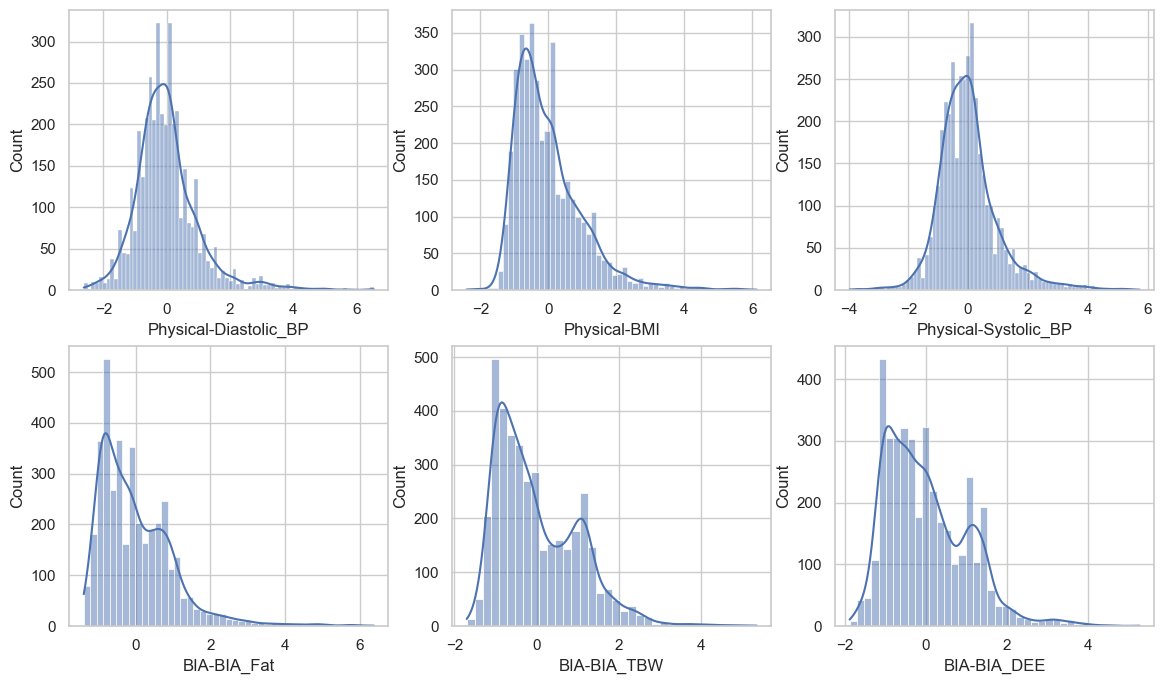

In [122]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=scaled_df['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=scaled_df['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=scaled_df['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=scaled_df['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=scaled_df['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=scaled_df['BIA-BIA_DEE'], ax=ax6)
plt.show()

# Unsupervised Learning

## Splitting the Data for Cross-Validation

In [217]:
X_scaled = scaled_df.drop(['sii', 'id'], axis=1)
y_scaled = scaled_df['sii']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3122, 39) (781, 39) (3122,) (781,)


## K-Means Clustering

In [218]:
kmeans = KMeans(n_clusters = 4, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=4, random_state=42)

In [219]:
train_clusters = kmeans.labels_

In [220]:
# Count points per cluster
cluster_counts = pd.Series(train_clusters).value_counts().sort_index()
print("Points per cluster:")
for cluster, count in cluster_counts.items():
   print(f"Cluster {cluster}: {count}")

Points per cluster:
Cluster 0: 244
Cluster 1: 1549
Cluster 2: 761
Cluster 3: 568


In [221]:
# Map clusters to most common sii value
cluster_to_sii = pd.Series(y_train.values, index=pd.Series(train_clusters)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
cluster_to_sii

0    2.0
1    0.0
2    0.0
3    1.0
dtype: float64

In [222]:
test_clusters = kmeans.predict(X_test)
predictions = pd.Series(test_clusters).map(cluster_to_sii)
predictions.head()

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [224]:
print(f"\nAccuracy: {accuracy_score(y_test, predictions):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, predictions, zero_division=True))


Accuracy: 0.787

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86       443
         1.0       0.86      0.46      0.60       265
         2.0       0.95      0.77      0.85        70
         3.0       1.00      0.00      0.00         3

    accuracy                           0.79       781
   macro avg       0.89      0.56      0.58       781
weighted avg       0.81      0.79      0.77       781



### Tuning the model

In [228]:
k_range = range(2, 15)
accuracies = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)

    train_clusters = kmeans.labels_
    
    # Get cluster SII mappings
    cluster_to_sii = pd.Series(y_train.values, index=pd.Series(train_clusters)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
    
    # Predict on CV set
    test_clusters = kmeans.predict(X_test)
    predictions = pd.Series(test_clusters).map(cluster_to_sii)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    print(f'k={k}, accuracy={acc:.3f}')

k=2, accuracy=0.695
k=3, accuracy=0.657
k=4, accuracy=0.787
k=5, accuracy=0.762
k=6, accuracy=0.787
k=7, accuracy=0.809
k=8, accuracy=0.803
k=9, accuracy=0.818
k=10, accuracy=0.813
k=11, accuracy=0.805
k=12, accuracy=0.794
k=13, accuracy=0.793
k=14, accuracy=0.799


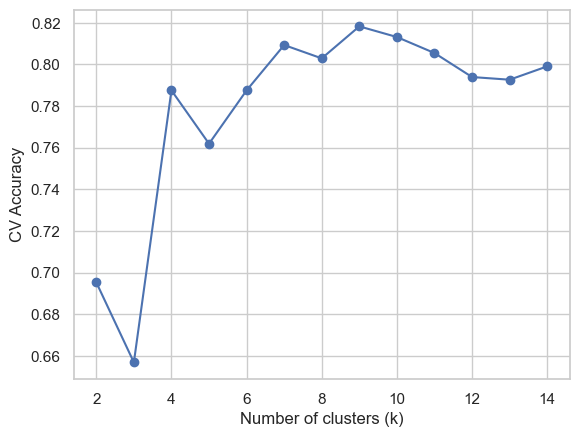


Best k = 9 with accuracy = 0.818


In [229]:
# Plot results
plt.plot(k_range, accuracies, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

best_k = k_range[np.argmax(accuracies)]
print(f'\nBest k = {best_k} with accuracy = {max(accuracies):.3f}')

## DBSCAN

In [232]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
train_clusters_db = dbscan.fit_predict(X_train)

In [233]:
# Count DBSCAN clusters
db_counts = pd.Series(train_clusters_db).value_counts().sort_index()
print("DBSCAN clusters:")
for cluster, count in db_counts.items():
    print(f"Cluster {cluster}: {count}")

DBSCAN clusters:
Cluster -1: 2512
Cluster 0: 440
Cluster 1: 37
Cluster 2: 95
Cluster 3: 14
Cluster 4: 8
Cluster 5: 6
Cluster 6: 5
Cluster 7: 5


In [235]:
# Map DBSCAN clusters to sii
db_cluster_to_sii = pd.Series(y_train.values, index=pd.Series(train_clusters_db)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
db_cluster_to_sii

-1    0.0
 0    0.0
 1    0.0
 2    1.0
 3    1.0
 4    1.0
 5    0.0
 6    1.0
 7    1.0
dtype: float64

In [236]:
test_clusters_db = dbscan.fit_predict(X_test)
db_predictions = pd.Series(test_clusters_db).map(db_cluster_to_sii)
print(f"\nDBSCAN Accuracy: {accuracy_score(y_test, db_predictions):.3f}")


DBSCAN Accuracy: 0.562


### Tuning the Model

In [242]:
# Try different eps values
eps_range = np.arange(0.1, 1.9, 0.1)
accuracies = []

for eps in eps_range:

    # DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=5)
    train_clusters_db = dbscan.fit_predict(X_train)
    
    # Map DBSCAN clusters to sii
    db_cluster_to_sii = pd.Series(y_train.values, index=pd.Series(train_clusters_db)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
    test_clusters_db = dbscan.fit_predict(X_test)
    db_predictions = pd.Series(test_clusters_db).map(db_cluster_to_sii)

    acc = accuracy_score(y_test, db_predictions)
    accuracies.append(acc)
    print(f'eps={eps:.1f}, accuracy={acc:.3f}')

eps=0.1, accuracy=0.563
eps=0.2, accuracy=0.563
eps=0.3, accuracy=0.563
eps=0.4, accuracy=0.543
eps=0.5, accuracy=0.543
eps=0.6, accuracy=0.543
eps=0.7, accuracy=0.543
eps=0.8, accuracy=0.543
eps=0.9, accuracy=0.543
eps=1.0, accuracy=0.551
eps=1.1, accuracy=0.551
eps=1.2, accuracy=0.577
eps=1.3, accuracy=0.581
eps=1.4, accuracy=0.561
eps=1.5, accuracy=0.562
eps=1.6, accuracy=0.567
eps=1.7, accuracy=0.567
eps=1.8, accuracy=0.567


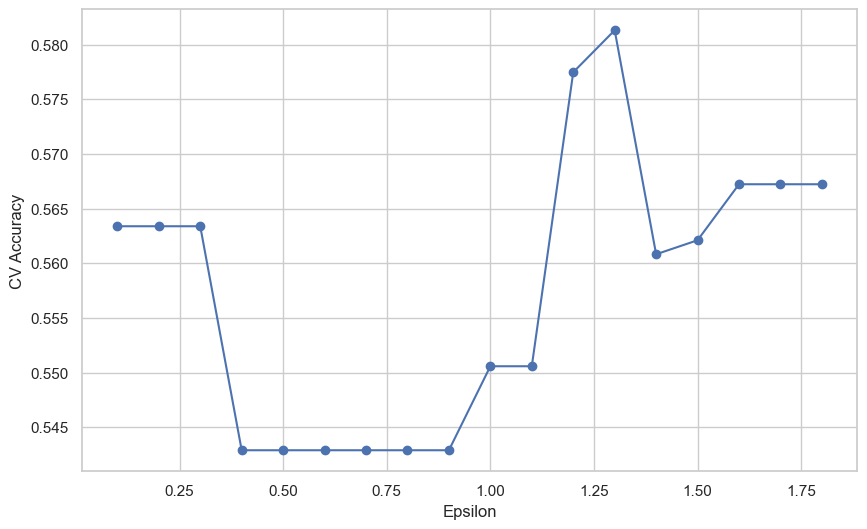


Best eps = 1.3 with accuracy = 0.581


In [243]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(eps_range, accuracies, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

best_eps = eps_range[np.argmax(accuracies)]
print(f'\nBest eps = {best_eps:.1f} with accuracy = {max(accuracies):.3f}')

In [174]:
# Use best eps value
best_dbscan = DBSCAN(eps=best_eps, min_samples=5)
best_dbscan.fit(scaled_train_df.drop('id', axis=1))

# Get final predictions and report
clusters = best_dbscan.labels_
unique, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique, counts))
cluster_sii = scaled_train_df.groupby(best_dbscan.labels_)['sii'].mean().round(0).to_dict()

cv_clustering_df = scaled_cv_df.copy()
cv_clustering_df['dbscan_cluster'] = best_dbscan.fit_predict(scaled_cv_df.drop('id', axis=1))
cv_clustering_df['dbscan_sii'] = cv_clustering_df['dbscan_cluster'].map(cluster_sii)

print("\nCluster Distribution:", cluster_counts)
print("\nCluster SII Mappings:", cluster_sii)
print("\nClassification Report:")
print(classification_report(cv_clustering_df['sii'], cv_clustering_df['dbscan_sii'], zero_division=0))


Cluster Distribution: {np.int64(-1): np.int64(2557), np.int64(0): np.int64(353), np.int64(1): np.int64(30), np.int64(2): np.int64(34), np.int64(3): np.int64(91), np.int64(4): np.int64(21), np.int64(5): np.int64(13), np.int64(6): np.int64(8), np.int64(7): np.int64(5), np.int64(8): np.int64(5), np.int64(9): np.int64(5)}

Cluster SII Mappings: {-1: 1.0, 0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 1.0, 7: 0.0, 8: 1.0, 9: 1.0}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.14      0.23       443
         1.0       0.33      0.86      0.48       265
         2.0       0.00      0.00      0.00        70
         3.0       0.00      0.00      0.00         3

    accuracy                           0.37       781
   macro avg       0.24      0.25      0.18       781
weighted avg       0.47      0.37      0.29       781



## Agglomerative Hierarchical Clustering

In [244]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
train_clusters_h = hierarchical.fit_predict(X_train)

In [245]:
# Count Hierarchical clusters
h_counts = pd.Series(train_clusters_h).value_counts().sort_index()
print("\nHierarchical clusters:")
for cluster, count in h_counts.items():
    print(f"Cluster {cluster}: {count}")


Hierarchical clusters:
Cluster 0: 1471
Cluster 1: 526
Cluster 2: 893
Cluster 3: 232


In [246]:
# Map Hierarchical clusters to sii
h_cluster_to_sii = pd.Series(y_train.values, index=pd.Series(train_clusters_h)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
h_cluster_to_sii

0    0.0
1    1.0
2    0.0
3    2.0
dtype: float64

In [247]:
# Predict on CV set
test_clusters_h = hierarchical.fit_predict(X_test)
h_predictions = pd.Series(test_clusters_h).map(h_cluster_to_sii)

In [248]:
print(f"\nHierarchical Accuracy: {accuracy_score(y_test, h_predictions):.3f}")


Hierarchical Accuracy: 0.266


### Tuning the Model

In [251]:
# Hierarchical parameter tuning
n_clusters_range = range(2, 11)
accuracies = []

for n in n_clusters_range:
    hierarchical = AgglomerativeClustering(n_clusters=n)
    
    train_clusters = hierarchical.fit_predict(X_train)
    
    cluster_sii = pd.Series(y_train.values, index=pd.Series(train_clusters)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
    
    test_clusters = hierarchical.fit_predict(X_test)
    predictions = pd.Series(test_clusters).map(cluster_sii)
    
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    print(f'n_clusters={n}, accuracy={acc:.3f}')

n_clusters=2, accuracy=0.352
n_clusters=3, accuracy=0.352
n_clusters=4, accuracy=0.266
n_clusters=5, accuracy=0.526
n_clusters=6, accuracy=0.561
n_clusters=7, accuracy=0.440
n_clusters=8, accuracy=0.333
n_clusters=9, accuracy=0.414
n_clusters=10, accuracy=0.343


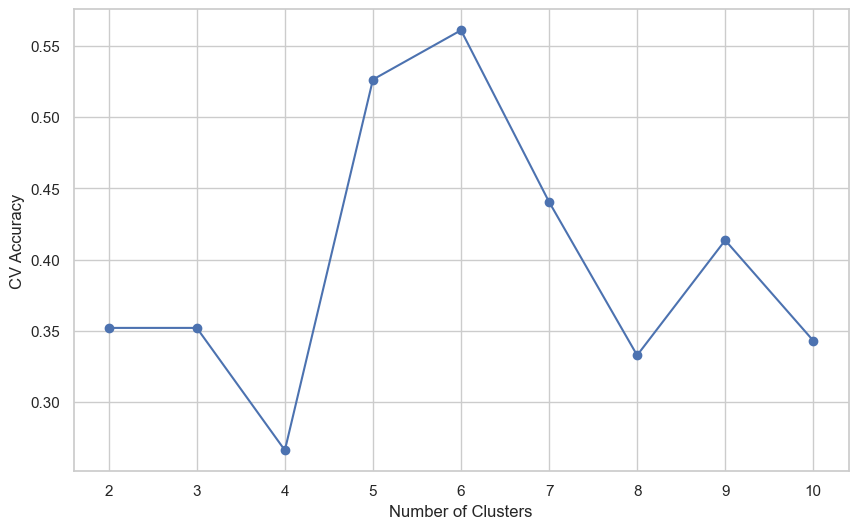

In [252]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, accuracies, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

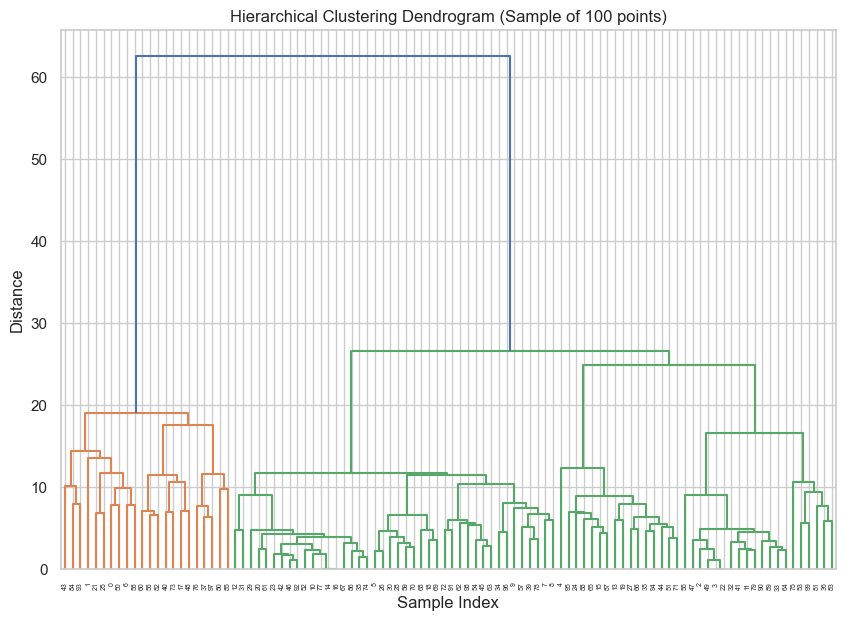

In [253]:
# Plot dendrogram for visualization
plt.figure(figsize=(10, 7))
linkage_matrix = linkage(X_train.sample(n=100), 'ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (Sample of 100 points)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Test Data Results